# AI Community @ Семинар  №5

## Визуализация и t-SNE

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

Источик материалов по t-SNE: [Google TechTalk with Laurens van der Maaten](https://www.youtube.com/watch?v=RJVL80Gg3lA&list=UUtXKDgv1AVoG88PLl8nGXmw)  
Ссылка на статьи, реализации и примеры: https://lvdmaaten.github.io/tsne/

У нас есть $N$ точек из простраства высокой размерности $x_1, x_2, ..., x_N$.  
**Задача:** отобразить эти точки в 2D или 3D пространстве, воспринимаемом человеком, так, чтобы различия между точками в исходном пространстве отражалось в сжатом пространстве.

Так работает PCA на изображениях цифр из датасета MNIST:

![PCA for MNIST](data/pca_mnist.png)
Источник: [High Dimensional Data Visualizing using tSNE](http://yinsenm.github.io/2015/01/01/High-Dimensional-Data-Visualizing-using-tSNE/#toc-Section-2)

Разные классы объектов довольно сильно пересекаются. Если мы уберем цветовую раскраску, то отличить некоторые классы на этой картинке будет просто невозможно.

**Переформулируем немного задачу:** нам необходимо разместить точки из пространства высокой размерности в пространстве низкой размерности так, чтобы близкие объекты в исходном пространстве были близки в новом, и наоборот, далекие объекты в исходном пространстве были так же далеки в новом.

Чтобы измерить похожесть объектов, введем условную вероятность присутствия в определенном месте одной точки при условии присутствия другой:  
$$p_{j|i}=\frac{exp(-\lVert{x_i - x_j}\rVert^2 / 2\sigma_i^2)}{\sum_{k\neq{i}}{exp(-\lVert{x_i - x_k}\rVert^2/2\sigma_i^2)}}$$
где $\sigma_i^2$ - дисперсия нормального распределения, которое моделирует близость объекта $j$ к объекту $i$.

![Гауссиана для точки x_i](data/t_sne_gaussian.png)

То же самое сделаем для точек из пространства малой размерности:  
$$q_{j|i}=\frac{exp(-\lVert{y_i - y_j}\rVert^2)}{\sum_{k\neq{i}}{exp(-\lVert{y_i - y_k}\rVert^2)}}$$

Это выражение взято из оригинальной версии SNE алгоритма. В алгоритме t-SNE вместо нормального распределения используется t-распределение Стьюдента со степению свободы 1 ([Wikipedia](https://en.wikipedia.org/wiki/Student%27s_t-distribution)). Эта модификация сделана для ускорения процесса сходимости, о котором мы скажем позже. Итак,
$$q_{j|i} = \frac{(1 + \lVert{y_i - y_j}\rVert^2)^{-1}}{\sum_{k\neq{i}}{(1 + \lVert{y_i - y_k}\rVert^2)^{-1}}}$$

Мы получили две функции измерения похожести объектов в двух различных пространствах (!). Т.е., если наша модель идеально предсталяет точки в новом пространстве, то $p_{j|i}$ будет равен $q_{j|i}$.

Поскольку точки $y_i$ - это те точки, которые мы собираемся сгенерировать, нам нужно генерировать их по определенному закону. Введем расстояние Кульбака-Лейблера для измерения расстояния между $P_i$ и $Q_i$, где $P_i$ - условное распределение вероятности всех точек $x_j$ кроме $j\neq{i}$, имея $x_i$, а $Q_i$ - условное распределение вероятности всех точек $y_j$ кроме $j\neq{i}$, имея $y_i$:  
$$C = \sum_{i}{KL({P_i}\lVert{Q_i})} = \sum_{i}{\sum_{j}{p_{j|i}log\frac{p_{j|i}}{q_{j|i}}}}$$

$C(y)$ - функция потерь, которую нам необходимо минимизировать. Для нахождения оптимального решения (точек $y_i$) мы можем использовать метод градиентного спуска. После схождения метода, полученные точки можно отрисовать в нашем "человеко-читаемом" пространстве. Результат работы алгоритма t-SNE на датасете MNIST:

![t-SNE for MNIST](data/t_sne_mnist.png)

### Примеры визуализации с t-SNE

In [1]:
import numpy as np
from sklearn.manifold import TSNE, Isomap
from sklearn.datasets import load_digits, fetch_olivetti_faces

from skimage.io import *
from skimage.transform import resize

import matplotlib.pyplot as plt

% matplotlib inline

#### t-SNE на MNIST

In [2]:
digits = load_digits()
digits_imgs = digits.images
digits_labels=digits.target

/home/vladvin/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


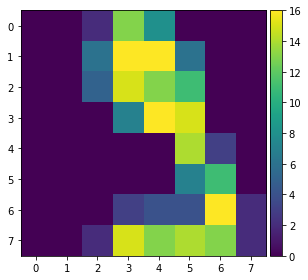

In [3]:
imshow(digits.images[31])

In [4]:
print(digits_imgs.shape)
digits_ravel = digits_imgs.reshape((digits_imgs.shape[0],) + (digits_imgs.shape[1] * digits_imgs.shape[2],))
print(digits_ravel.shape)

(1797, 8, 8)
(1797, 64)


In [5]:
tsne = TSNE(n_components=2)
digits2d = tsne.fit_transform(digits_ravel, digits.target)

In [6]:
def plot_2d_data(data, labels, labels_limit=10):
    plt.figure(figsize=(10, 10))
    
    unique_labels = np.sort(np.unique(labels))
    for i, label in enumerate(unique_labels):
        same_objects = data[labels == label]
        plt.scatter(same_objects[:, 0], same_objects[:, 1], label=str(label))
        
        if i + 1 >= labels_limit:
            break
    
    plt.legend(loc='best')

In [7]:
def plot_2d_images(images, points, img_size=(20, 20)):    
    size = points[:, 0].max() - points[:, 0].min(), points[:, 1].max() - points[:, 1].min()
    plot_size = int(size[0]) * 10, int(size[1]) * 10
    size_diff = img_size[0] * 3, img_size[1] * 3
    plot_size = plot_size[0] + size_diff[0], plot_size[1] + size_diff[1]
    
    plot_points = (points - points.min(axis=0)) * 10 + 10
    out_plot = np.ones(shape=plot_size)
#     print(plot_size)
    for i, point in enumerate(plot_points):
        img = images[i]
        img = resize(img, img_size)
        x, y = int(point[0]), int(point[1])
#         print(i, x, y)
        out_plot[x - img_size[0]//2:x + img_size[0]//2, y - img_size[1]//2:y + img_size[1]//2] = img
    
    plt.figure(figsize=(15, 15))
    imshow(out_plot)

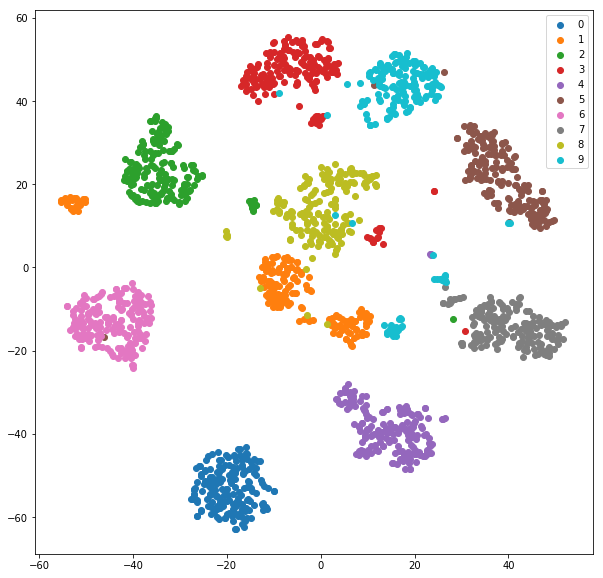

In [8]:
plot_2d_data(digits2d, digits_labels)

/home/vladvin/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/vladvin/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


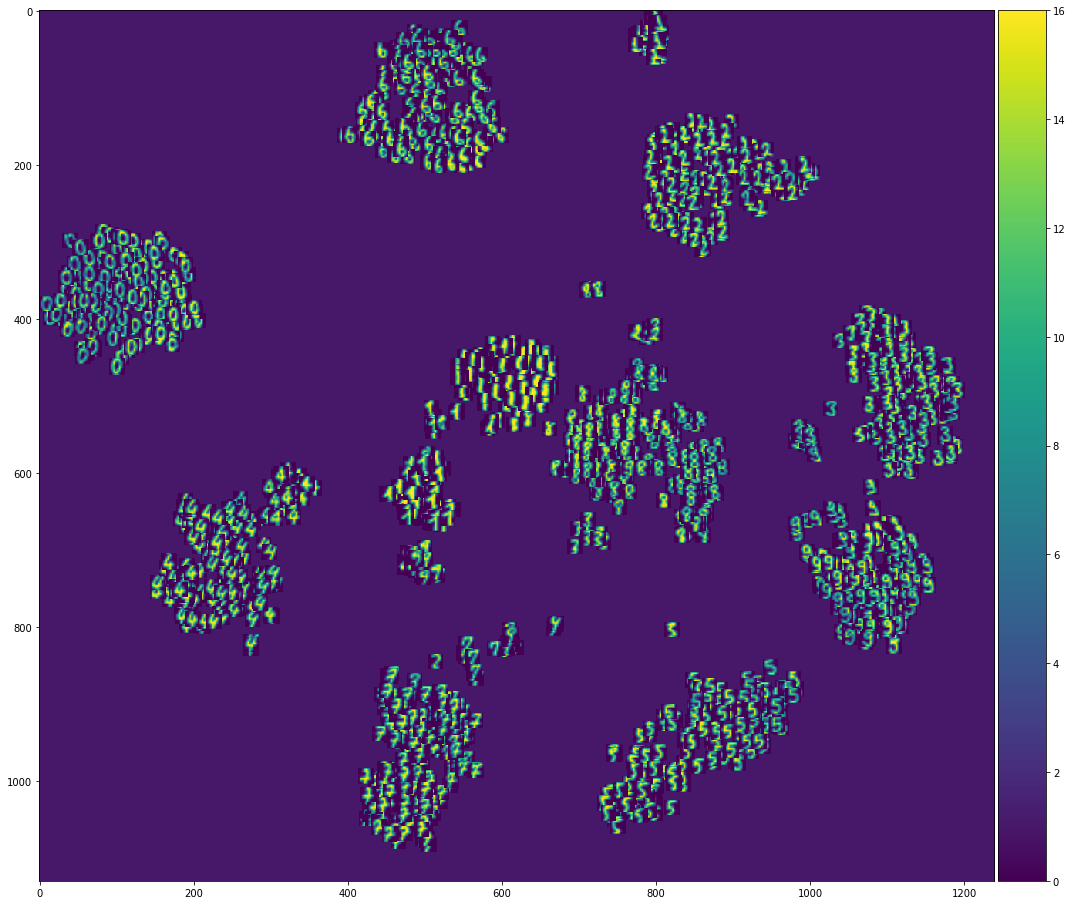

In [9]:
plot_2d_images(digits_imgs, digits2d)

#### t-SNE на лицах из датасета Olivetti

In [11]:
faces = fetch_olivetti_faces()
faces_ravel = faces.data
faces_images = faces.images
faces_labels = faces.target

In [12]:
tsne = TSNE(n_components=2)
faces_tsne = tsne.fit_transform(faces_ravel)

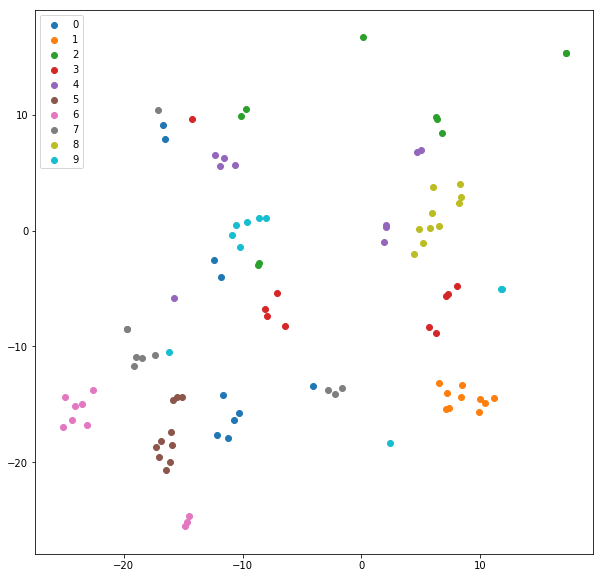

In [13]:
plot_2d_data(faces_tsne, faces_labels)

/home/vladvin/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


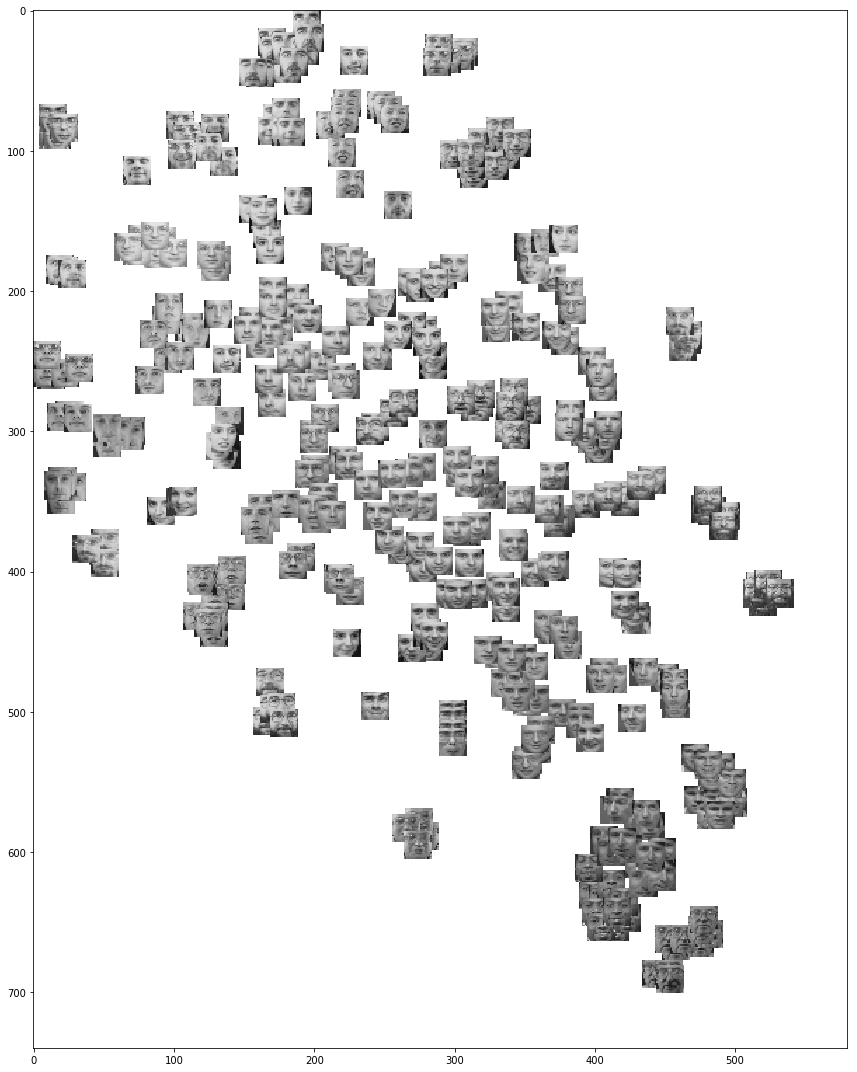

In [14]:
plot_2d_images(faces_images, faces_tsne, img_size=(20, 20))

### Визуализация с помощью Isomap

#### Isomap на MNIST

In [15]:
isomap = Isomap()
digits_isomap = isomap.fit_transform(digits_ravel)

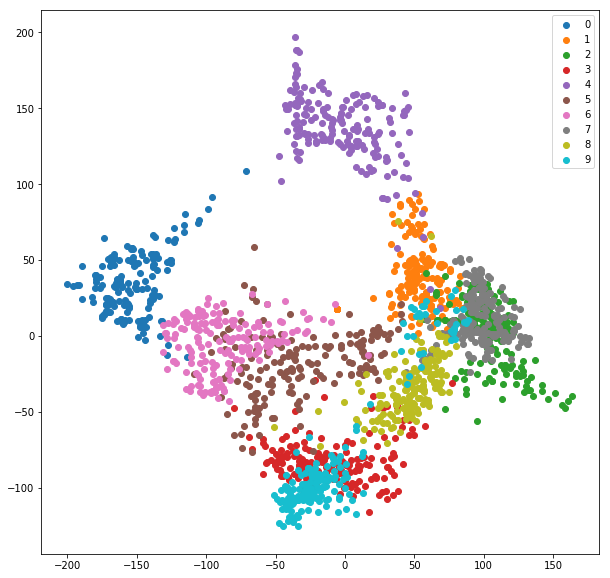

In [16]:
plot_2d_data(digits_isomap, digits_labels)

#### Isomap на лицах из датасета Olivetti

In [17]:
isomap = Isomap()
faces_isomap = isomap.fit_transform(faces_ravel)

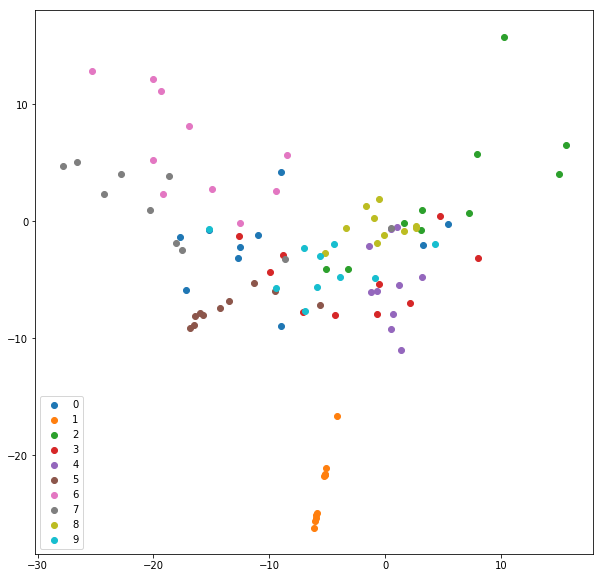

In [18]:
plot_2d_data(faces_isomap, faces_labels)